<center><h1><b>Project

---

Installations

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<center><b><i>Dataset loading

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dsl_data.zip -d /content/dsl_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/bb584980-4501-11e9-a1ea-79ca03012c0e.wav  
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/1d466520-4500-11e9-a1ea-79ca03012c0e.wav  
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/51c7dcc0-4500-11e9-a1ea-79ca03012c0e.wav  
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/4efef8c0-4500-11e9-a1ea-79ca03012c0e.wav  
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/4bb10640-4500-11e9-a1ea-79ca03012c0e.wav  
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/45d42b80-4500-11e9-a1ea-79ca03012c0e.wav  
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/63247140-4500-11e9-a1ea-79ca03012c0e.wav  
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/bdb80b70-4501-11e9-a1ea-79ca03012c0e.wav  
  inflating: /content/dsl_data/audio/speakers/9MX3AgZzVgCw4W4j/17338640-4500-11e9-a1ea-79ca03012c0e.w

---

<center><b><i>Imports

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
import os 
import imblearn
import plotly.express as px
import sklearn
import librosa
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from prettytable import PrettyTable
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [ ]:
# versions check
print(imblearn.__version__)
print(torch.__version__)
print(torchaudio.__version__)

0.8.1
1.13.1+cu116
0.13.1+cu116


---

<center><b><i>Data preprocessing

Dataset inspection and preprocessing

In [ ]:
# reading the csv files 
dev = pd.read_csv('/content/dsl_data/development.csv')
eval = pd.read_csv('/content/dsl_data/evaluation.csv')

# saving all the paths into a list 
dev_paths = dev['path']

In [ ]:
dev.head()

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40


Histogram of the length of the signals (in seconds)

In [ ]:
# histogram of the duration of the recordings
length = []
outliers = []
for au_idx, au_val in enumerate(dev_paths):
    samplerate, data = wavfile.read(au_val)
    l = data.shape[0] / samplerate
    if l >= 10: 
        outliers.append(au_idx)
    length.append(l)
lengths = pd.DataFrame(length, columns=['Length(s)'])
leng = px.histogram(
    lengths, 
    x = 'Length(s)', 
    color_discrete_sequence=['indianred'], 
    marginal='box',
    width = 700,
    height = 500
)
leng.update_xaxes(showgrid=True, dtick = 1) 
leng.show()

---

Audio Loading: saving the wav into a list and then into a pickle file

In [ ]:
audio = []
for path in dev['path']:
  a, s = librosa.load(path)
  audio.append(a)
  
audio_eval = []
for path in eval['path']:
  a, s = librosa.load(path)
  audio_eval.append(a)

In [ ]:
out_df = pd.DataFrame({'audio' : audio})
out_df.to_pickle('/content/drive/MyDrive/audio.pkl')
out_df_eval = pd.DataFrame({'audio' : audio_eval})
out_df_eval.to_pickle('/content/drive/MyDrive/audio_eval.pkl')

---

Read pickle file

In [ ]:
def read_audio_pkl(path):
  audio_df = pd.read_pickle(path)
  sr = 22050
  return audio_df, sr

dev_audio, sr = read_audio_pkl('/content/drive/MyDrive/audio.pkl')
eval_audio, sr = read_audio_pkl('/content/drive/MyDrive/audio_eval.pkl')

In [ ]:
dev = pd.read_csv('/content/dsl_data/development.csv')
eval = pd.read_csv('/content/dsl_data/evaluation.csv')

In [ ]:
dev.head()

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40


In [ ]:
dev_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9854 entries, 0 to 9853
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   audio   9854 non-null   object
dtypes: object(1)
memory usage: 77.1+ KB


Data preparation: cleaning the dataset (both dev and eval)

In [ ]:
def clear_dev(df):
  #df['object'].replace(to_replace='none', value='', inplace=True)
  y = dev['action'].map(str) + dev['object'].map(str)
  df.drop(columns=['action', 'object', 'Id', 'path', 'speakerId'], inplace=True)
  df.rename(columns = {'Self-reported fluency level ':'Self-reported fluency level'}, inplace=True)
  return df, y

def clear_eval(df):
  id_eval = df['Id']
  df.drop(columns=['Id', 'path', 'speakerId'], inplace=True)
  df.rename(columns = {'Self-reported fluency level ':'Self-reported fluency level'}, inplace=True)
  return df, id_eval

filtered_audio_data = []
'''
tol = 1e-04
for i in range(len(dev_audio)):
    tmp = dev_audio['audio'].iloc[i]
    dev_audio['audio'].iloc[i] = np.array(tmp[(tmp>=tol) | (tmp<=-tol)])

for i in range(len(eval_audio)):
    tmp = eval_audio['audio'].iloc[i]
    eval_audio['audio'].iloc[i] = np.array(tmp[(tmp>=tol) | (tmp<=-tol)])
'''
dev, y_true = clear_dev(dev)
eval, id_eval = clear_eval(eval)
dev.head()

,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,advanced,English (United States),English (United States),female,22-40
1,advanced,English (United States),English (United States),female,22-40
2,advanced,English (United States),English (United States),female,22-40
3,advanced,English (United States),English (United States),female,22-40
4,advanced,English (United States),English (United States),female,22-40


In [ ]:
y_true = pd.DataFrame(y_true)
y_true.rename(columns = {0 : 'instruction'}, inplace = True)
y_true

,instruction
0,change languagenone
1,activatemusic
2,deactivatelights
3,increasevolume
4,increasevolume
...,...
9849,decreasevolume
9850,deactivatelights
9851,deactivatelights
9852,deactivatelights


In [ ]:
import librosa

def add_features(df, t):
    if t == 'stft':
        df['stft_audio'] = df['audio'].apply(lambda x: np.abs(librosa.stft(x, n_fft=512)))
    if t == 'spectral_centroid':
        df['spectral_centroid'] = df['audio'].apply(lambda x: librosa.feature.spectral_centroid(y=x, sr=sr)[0])
    if t == 'mfcc':
        df['mfcc'] = df['audio'].apply(lambda x: librosa.feature.mfcc(S=librosa.power_to_db(librosa.feature.melspectrogram(y=x, sr=sr))))
    return df

def add_audio_features(df, audio, t):
    df['audio'] = audio['audio']
    if t == 'stft':
        df['stft_audio'] = audio['stft_audio']
    if t == 'spectral_centroid':
        df['spectral_centroid'] = audio['spectral_centroid']
    if t == 'mfcc':
        df['mfcc'] = audio['mfcc']
    return df

'''
for i in range(len(dev_audio)):
  dev_audio['audio'].iloc[i] = np.pad(dev_audio['audio'].iloc[i], (0, 62657-len(dev_audio['audio'].iloc[i])))
'''

t = 'mfcc'
dev_audio = add_features(dev_audio, t)
eval_audio = add_features(eval_audio, t)
dev = add_audio_features(dev, dev_audio, t)
eval = add_audio_features(eval, eval_audio, t)

In [ ]:
dev.drop(columns = ['Self-reported fluency level',	'First Language spoken', 'Current language used for work/school', 'gender', 'ageRange'], inplace = True)

In [ ]:
dev.head()

,audio,stft_audio
0,"[-0.00018625158, -0.00019312432, -0.0001415973...","[[0.008554462, 0.005914496, 0.0004330445, 0.00..."
1,"[-0.000111761816, -0.00012734804, -0.000120628...","[[0.009927612, 0.0101816505, 0.010074423, 0.00..."
2,"[-0.00010095282, -0.00010055412, 0.00010385692...","[[0.00512217, 0.0056081503, 0.0031105506, 0.00..."
3,"[-0.00017154313, -0.00019777234, -0.0001000748...","[[0.0039048963, 0.002285785, 0.0021602947, 0.0..."
4,"[0.00013900887, 0.0002094963, 0.0002184959, 0....","[[0.013297699, 0.0089086415, 0.013035539, 0.01..."


In [ ]:
#mfcc_features = pd.DataFrame(np.array(dev['mfcc'].tolist()).reshape(-1, 20*123))

In [ ]:
def syntetize(spectr, N, M):
    """
    This function is used to syntetize a given matrix "spectr" of shape spectr.shape[0]xspectr.shape[1] into an intermediate matrix
    of dimension NxM to then finally flatten this intermediate matrix into an array of lenght NxM.
    This particular function has been defined in the context of spectrum analysis, hence the intermediate matrix is not just one, but two, and
    the final array contains 2*NxM elements. 

    ---------
    Paramethers:
    spectr: the given matrix to syntetize in the output array.
    N: scalar. Number of rows in the intermediate matrix.
    M: scalar. Number of columns in the intermediate matrix. 

    Returns: 
    An (NxM*2,) array that serves as a syntesis of the given spectrum.
    """

    synt = np.zeros(shape = (N, M))
    N_in, M_in = spectr.shape

    n_positions = [n*N_in//N for n in range(N+1)]
    m_positions = [m*M_in//M for m in range(M+1)]

    combinations = set()
    for n_pos in n_positions:
        for m_pos in m_positions:
            combinations.add((n_pos, m_pos))

    output_mean = np.ones(shape = (N, M))
    output_std = np.ones(shape = (N, M))

    # populating the output dataset with the summaryzed data 
    for r_idx in range(len(n_positions)-1):
        r_start_pos = n_positions[r_idx]
        r_end_pos = n_positions[r_idx + 1]

        for c_idx in range(len(m_positions)-1):
            c_start_pos = m_positions[c_idx]
            c_end_pos = m_positions[c_idx + 1]

            output_mean[r_idx, c_idx] = np.mean(spectr[r_start_pos:r_end_pos, c_start_pos:c_end_pos])
            output_mean[r_idx, c_idx] = np.std(spectr[r_start_pos:r_end_pos, c_start_pos:c_end_pos])
    
    mean_row = output_mean.flatten()
    std_row = output_std.flatten()

    return np.hstack((mean_row, std_row))

About 8min

In [ ]:
final_list = []
N = 32
M = 32
if dev.columns[1] == 'stft_audio':
    for el in dev['stft_audio'].to_numpy():
        final_list.append(syntetize(el, N, M).flatten())
if dev.columns[1] == 'mfcc':
    for el in dev['mfcc'].to_numpy():
        final_list.append(syntetize(el, N, M).flatten())
features = pd.DataFrame(final_list)
features.head()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


---

Data Exploration: check weather the instructions are balanced or not. In case they are not balaced, fix it

In [ ]:
instr = px.histogram(
    y_true, x='instruction', 
    color_discrete_sequence = ['indianred'], 
    text_auto=True, 
    width = 700,
    height = 400
    )
instr.show()

In [ ]:
le = LabelEncoder()
encoded_labels = le.fit_transform(y_true)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
for i in range(len(features)):
  if np.isnan(features.iloc[i]).any():
    features.iloc[i] = np.nan_to_num(features.iloc[i])
print(len(features), len(encoded_labels))
oversample = SMOTE()
features, labels = oversample.fit_resample(features, encoded_labels)

9854 9854


In [ ]:
y_hat = []
for i in labels:
    if i == 0:
        y_hat.append('activatemusic')
    if i == 1:
        y_hat.append('changelanguage')
    if i == 2:
        y_hat.append('deactivatelights')
    if i == 3:
        y_hat.append('decreaseheat')
    if i == 4:
        y_hat.append('decreasevolume')
    if i == 5:
        y_hat.append('increaseheat')
    if i == 6:
        y_hat.append('increasevolume')

In [ ]:
y_true = pd.DataFrame(y_hat)
y_true.rename(columns={0:'instruction'}, inplace=True)
y_true.head()


,instruction
0,changelanguage
1,activatemusic
2,deactivatelights
3,increasevolume
4,increasevolume


In [ ]:
instr = px.histogram(
    y_true, x='instruction', 
    color_discrete_sequence = ['indianred'], 
    text_auto=True, 
    width = 700,
    height = 400
    )
instr.show()

In [ ]:
y_true = y_true.to_numpy()

---

Signals plot

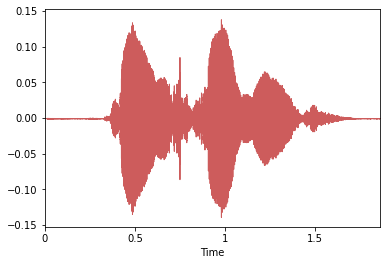

In [ ]:
import librosa.display

audio_signal, s = librosa.load(dev['path'].iloc[0])
sr = 22050
librosa.display.waveplot(audio_signal, color='#cd5c5c')

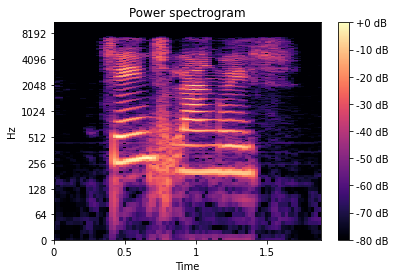

In [ ]:
import matplotlib.pyplot as plt

ft = np.abs(librosa.stft(audio_signal))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(ft, ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

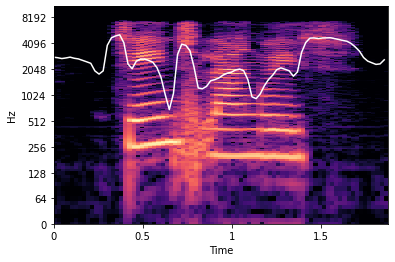

In [ ]:
spec_centroid = librosa.feature.spectral_centroid(y=audio_signal, sr=sr)[0]
frames = range(len(spec_centroid))
t = librosa.frames_to_time(frames)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(ft, ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.plot(t, spec_centroid.T, label='Spectral centroid', color='w')

[Text(0.5, 1.0, 'MFCC')]

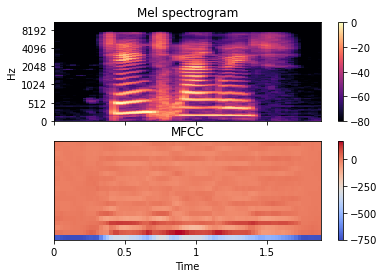

In [ ]:
S = librosa.feature.melspectrogram(y=audio_signal, sr=sr)
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

[ 0.00011511  0.00015909 -0.00010113 ...  0.00012869  0.00017713
  0.00010559]


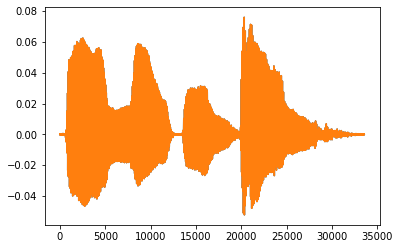

In [ ]:
a = dev_audio['audio'].iloc[60]
tol = 1e-04
b = a[(a >= tol) | (a<=-tol)]
plt.plot(a)
plt.plot(b)
print(a)

---

<center><b><h1>STFT

Random Forest

In [ ]:
# creating the pretty table
table = PrettyTable()
table.field_names = ["Parameter", "Value", "Mean Test Score"]

# defining parameters
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 2, 5, 10, 50],
    'criterion' : ['gini', 'entropy']
}

# creating X, y
X, y = features, y_true

# spliting into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.2, random_state=42, shuffle=True)

# grid search 
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)

# fitting the model for grud search 
grid.fit(X_train, y_train)

# add the grid search results to the table
for index, result in enumerate(grid.cv_results_['params']):
    table.add_row([index,result,grid.cv_results_['mean_test_score'][index]])

print(table)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# pass the best parameters found during grid search to a new RF object
best_model = RandomForestClassifier(**grid.best_params_)

# fit the best model 
best_model.fit(X_train, y_train)

# predict on the test sample
y_pred = best_model.predict(X_test)

# create a table
table2 = PrettyTable()
table2.field_names = ["Model", "Parameters", "Accuracy"]

# add the results to the table
table2.add_row([best_model.__class__.__name__, grid.best_params_, "{:.2f}%".format(accuracy_score(y_test, y_pred) * 100)])

# print the table
print(table2)

+-----------+------------------------------------------------------------------+---------------------+
| Parameter |                              Value                               |   Mean Test Score   |
+-----------+------------------------------------------------------------------+---------------------+
|     0     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}   |  0.7140263177026537 |
|     1     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}   |  0.7271144773801262 |
|     2     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}   |  0.7310407190773602 |
|     3     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 400}   |  0.7332946036152144 |
|     4     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}   |  0.7312589537688774 |
|     5     |    {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}    |  0.297606186180232  |
|     6     |    {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 20

In [ ]:
# creating X, y
X, y = features, y_true
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True )

# create the model using the best parameters 
rfc_model = RandomForestClassifier(criterion='gini', max_depth=None, n_estimators=2000)

# fit the best model 
rfc_model.fit(X_train, y_train)

# predict 
y_pred = rfc_model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.728688524590164


MLP

In [ ]:
# creating the pretty table
table = PrettyTable()
table.field_names = ["Parameter", "Value", "Mean Test Score"]

# defining parameters
param_grid = {
    'max_iter': [10_000, 100_000, 1_000_000],
    'learning_rate' : ['constant', 'invscaling', 'adaptive']
}

# creating X, y
X, y = features, y_true

# spliting into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.2, random_state=42, shuffle=True)

# grid search 
grid = GridSearchCV(MLPClassifier(), param_grid=param_grid)

# fitting the model for grid search 
grid.fit(X_train, y_train)

# add the grid search results to the table
for index, result in enumerate(grid.cv_results_['params']):
    table.add_row([index,result,grid.cv_results_['mean_test_score'][index]])

print(table)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# pass the best parameters found during grid search to a new MLP object
best_model = MLPClassifier(**grid.best_params_)

# fit the best model 
best_model.fit(X_train, y_train)

# predict on the test sample
y_pred = best_model.predict(X_test)

# create a table
table2 = PrettyTable()
table2.field_names = ["Model", "Parameters", "Accuracy"]

# add the results to the table
table2.add_row([best_model.__class__.__name__, grid.best_params_, "{:.2f}%".format(accuracy_score(y_test, y_pred) * 100)])

# print the table
print(table2)

+-----------+------------------------------------------------------+--------------------+
| Parameter |                        Value                         |  Mean Test Score   |
+-----------+------------------------------------------------------+--------------------+
|     0     |   {'learning_rate': 'constant', 'max_iter': 10000}   | 0.6223347807408877 |
|     1     |  {'learning_rate': 'constant', 'max_iter': 100000}   | 0.611505449258121  |
|     2     |  {'learning_rate': 'constant', 'max_iter': 1000000}  | 0.6189207230428605 |
|     3     |  {'learning_rate': 'invscaling', 'max_iter': 10000}  | 0.601978890320875  |
|     4     | {'learning_rate': 'invscaling', 'max_iter': 100000}  | 0.6188451934833614 |
|     5     | {'learning_rate': 'invscaling', 'max_iter': 1000000} | 0.6287360761376029 |
|     6     |   {'learning_rate': 'adaptive', 'max_iter': 10000}   | 0.6145581970192657 |
|     7     |  {'learning_rate': 'adaptive', 'max_iter': 100000}   | 0.6311370014209708 |
|     8   

In [ ]:
# creating X, y
X, y = features, y_true
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True )

# create the model using the best parameters 
rfc_model = MLPClassifier(learning_rate = 'adaptive', max_iter= 1_000_000)

# fit the best model 
rfc_model.fit(X_train, y_train)

# predict 
y_pred = rfc_model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.6830601092896175


<center><b><h1>MFCC

Random Forest 

In [ ]:
# creating the pretty table
table = PrettyTable()
table.field_names = ["Parameter", "Value", "Mean Test Score"]

# defining parameters
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 2, 5, 10, 50],
    'criterion' : ['gini', 'entropy']
}

# creating X, y
X, y = features, y_true

# spliting into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.2, random_state=42, shuffle=True)

# grid search 
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)

# fitting the model for grud search 
grid.fit(X_train, y_train)

# add the grid search results to the table
for index, result in enumerate(grid.cv_results_['params']):
    table.add_row([index,result,grid.cv_results_['mean_test_score'][index]])

print(table)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# pass the best parameters found during grid search to a new RF object
best_model = RandomForestClassifier(**grid.best_params_)

# fit the best model 
best_model.fit(X_train, y_train)

# predict on the test sample
y_pred = best_model.predict(X_test)

# create a table
table2 = PrettyTable()
table2.field_names = ["Model", "Parameters", "Accuracy"]

# add the results to the table
table2.add_row([best_model.__class__.__name__, grid.best_params_, "{:.2f}%".format(accuracy_score(y_test, y_pred) * 100)])

# print the table
print(table2)

+-----------+------------------------------------------------------------------+---------------------+
| Parameter |                              Value                               |   Mean Test Score   |
+-----------+------------------------------------------------------------------+---------------------+
|     0     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}   |  0.7102443409008294 |
|     1     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}   |  0.7173704239780576 |
|     2     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}   |  0.7260235154158818 |
|     3     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 400}   |  0.7313307557582367 |
|     4     |  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}   |  0.7303860678761442 |
|     5     |    {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}    | 0.24336504411618914 |
|     6     |    {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 20

MLP


In [ ]:
# creating the pretty table
table = PrettyTable()
table.field_names = ["Parameter", "Value", "Mean Test Score"]

# defining parameters
param_grid = {
    'max_iter': [10_000, 100_000, 1_000_000],
    'learning_rate' : ['constant', 'invscaling', 'adaptive']
}

# creating X, y
X, y = features, y_true

# spliting into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.2, random_state=42, shuffle=True)

# grid search 
grid = GridSearchCV(MLPClassifier(), param_grid=param_grid)

# fitting the model for grid search 
grid.fit(X_train, y_train)

# add the grid search results to the table
for index, result in enumerate(grid.cv_results_['params']):
    table.add_row([index,result,grid.cv_results_['mean_test_score'][index]])

print(table)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# pass the best parameters found during grid search to a new MLP object
best_model = MLPClassifier(**grid.best_params_)

# fit the best model 
best_model.fit(X_train, y_train)

# predict on the test sample
y_pred = best_model.predict(X_test)

# create a table
table2 = PrettyTable()
table2.field_names = ["Model", "Parameters", "Accuracy"]

# add the results to the table
table2.add_row([best_model.__class__.__name__, grid.best_params_, "{:.2f}%".format(accuracy_score(y_test, y_pred) * 100)])

# print the table
print(table2)

+-----------+------------------------------------------------------+---------------------+
| Parameter |                        Value                         |   Mean Test Score   |
+-----------+------------------------------------------------------+---------------------+
|     0     |   {'learning_rate': 'constant', 'max_iter': 10000}   |  0.5068685899342388 |
|     1     |  {'learning_rate': 'constant', 'max_iter': 100000}   |  0.5103630679752816 |
|     2     |  {'learning_rate': 'constant', 'max_iter': 1000000}  |  0.5427927431347278 |
|     3     |  {'learning_rate': 'invscaling', 'max_iter': 10000}  |  0.522728872145666  |
|     4     | {'learning_rate': 'invscaling', 'max_iter': 100000}  |  0.5686032847559565 |
|     5     | {'learning_rate': 'invscaling', 'max_iter': 1000000} | 0.49466180231981766 |
|     6     |   {'learning_rate': 'adaptive', 'max_iter': 10000}   |  0.5714436932024718 |
|     7     |  {'learning_rate': 'adaptive', 'max_iter': 100000}   |  0.4920498331185354 |

In [ ]:
# creating the pretty table
table = PrettyTable()
table.field_names = ["Parameter", "Value", "Mean Test Score"]

# defining parameters
param_grid = {
    'n_estimators': [5000],
    'max_depth': [None],
    'criterion' : ['gini']
}

# creating X, y
X, y = features, y_true

# spliting into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.2, random_state=42, shuffle=True)

# grid search 
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)

# fitting the model for grud search 
grid.fit(X_train, y_train)

# add the grid search results to the table
for index, result in enumerate(grid.cv_results_['params']):
    table.add_row([index,result,grid.cv_results_['mean_test_score'][index]])

print(table)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# pass the best parameters found during grid search to a new SVC object
best_model = RandomForestClassifier(**grid.best_params_)

# fit the best model 
best_model.fit(X_train, y_train)

# predict on the test sample
y_pred = best_model.predict(X_test)

# create a table
table2 = PrettyTable()
table2.field_names = ["Model", "Parameters", "Accuracy"]

# add the results to the table
table2.add_row([best_model.__class__.__name__, grid.best_params_, "{:.2f}%".format(accuracy_score(y_test, y_pred) * 100)])

# print the table
print(table2)

---

Testing

In [ ]:
eval.drop(columns = ['Self-reported fluency level', 'First Language spoken', 'Current language used for work/school', 'gender',	'ageRange'], inplace = True)
eval.head()

,audio,stft_audio
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 1.389573e-12, 0.0015344444, 0.005628354..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 8.667623e-06, 0.00030302777, 0.000..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 2.6961904e-13, 0.00062105095, 0.0065227..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 1.4873603e-12, 0.0007051165, 0.00091023..."


In [ ]:
final_list = []
N = 32
M = 32
if eval.columns[1] == 'stft_audio':
    for el in eval['stft_audio'].to_numpy():
        final_list.append(syntetize(el, N, M).flatten())
if eval.columns[1] == 'mfcc':
    for el in eval['mfcc'].to_numpy():
        final_list.append(syntetize(el, N, M).flatten())
eval_features = pd.DataFrame(final_list)
eval_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.016518,0.004006,0.006676,0.011128,0.052809,10.277956,4.269314,8.556646,13.780396,13.593469,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.000242,0.000140,0.000334,0.000044,0.000026,0.000042,0.000669,0.000402,0.065163,1.197589,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.004341,0.006586,0.004284,0.002920,0.002568,0.002734,0.003017,0.003765,0.003119,1.760306,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.022975,0.015644,0.018838,0.017750,0.018111,0.135145,4.733647,4.304725,1.462617,3.206173,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


MLP

In [ ]:
# creating X, y
X, y = features, y_true
y = y.ravel()

# create the model using the best parameters 
mlp_model = MLPClassifier(max_iter = 1_000_000_000, learning_rate = 'adaptive')

# fit the best model 
mlp_model.fit(X, y)

MLPClassifier(learning_rate='adaptive', max_iter=1000000000)

In [ ]:
y_hat = mlp_model.predict(eval_features)

Random Forest

In [ ]:
# creating X, y
X, y = features, y_true
y = y.ravel()

# create the model using the best parameters 
rfc_model = RandomForestClassifier(criterion='gini', max_depth=None, n_estimators=2000)

# fit the best model 
rfc_model.fit(X, y)

RandomForestClassifier(n_estimators=3000)

In [ ]:
y_hat = rfc_model.predict(eval_features)

In [ ]:
data = list(zip(id_eval, y_hat))
final_df = pd.DataFrame(data, columns = ['Id', 'Predicted'])
final_df.loc[final_df['Predicted'] == 'changelanguage', ['Predicted']] = 'change languagenone'
final_df

,Id,Predicted
0,0,decreasevolume
1,1,decreaseheat
2,2,increasevolume
3,3,deactivatelights
4,4,increasevolume
...,...,...
1450,1450,change languagenone
1451,1451,deactivatelights
1452,1452,increasevolume
1453,1453,decreaseheat


In [ ]:
s305206_s317721_eval = final_df.to_csv('/content/305206_s317721_eval.csv', index = False) 